## Analysis sparks

In [18]:
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Imagenes_confocal/Rata/C071112/'
photo_name = 'c3ack009'
x_calibracion = 4.5

import numpy as np                # funciones numéricas (arrays, matrices, etc.)
import matplotlib.pyplot as plt   # funciones para representación gráfica
%matplotlib inline
import cv2
from PIL import Image
import pandas as pd
import  csv
#     '''This function finds a tList in sec yList - measurements ySS - the steady state value of y returns amplitude of exponent tau - the time constant'''
from math import log
from pylab import lstsq
from pylab import matrix
from pylab import exp

In [19]:
class sparks_analysis ():
    import numpy
    from PIL import Image
    import cv2
    def __init__(self, path, photo_name, x_calibration):
        self.path = path
        self.photo_name = photo_name
        self.x_calibration = x_calibration
    def select_roi (image):
        fromCenter = False
        showCrosshair = False
        r = cv2.selectROI(image, fromCenter, showCrosshair)
        return r
    def crop_image (image, r):
        imCrop = image[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
        return imCrop
    def display_image (name , image):
        cv2.imshow(name, image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    def f(brightness, contrast):
        img = np.int16(imCrop)
        img = img * (contrast/127+1) - contrast + brightness
        img = np.clip(img, 0, 255)
        img = np.uint8(img)
        plt.imshow(img)
        plt.show()
        return img
    def rotation (image_path, degrees):
        im = Image.fromarray(image_path)
        im = im.rotate(degrees)
        im = numpy.array(im)
    def filtration (image):
        original = image.copy()
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (3, 3), 50)
        canny = cv2.Canny(blurred, 100, 250, 400)
        kernel = np.ones((5,5),np.uint8)
        dilate = cv2.dilate(canny, kernel, iterations=1)
        return dilate, original
    def find_contourns (image):
        cnts = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        return cnts
    def plot_histogram (y_data, nombre_foto, label_x, label_y):
        import matplotlib.pyplot as plt
        %matplotlib inline
        plt.plot(y_data)
        plt.title(nombre_foto)
        plt.xlabel(label_x)
        plt.ylabel(label_y)
        plt.show()
    def track_contours (c, image, track_number):
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(auto_result, (x, y), (x + w, y + h), (255,255,0), 2)
        cv2.putText(auto_result, str(track_number), (x-2, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0),2)
        ROI = original[y:y+h, x:x+w]
        x_data = np.asarray(range(x,x+w),dtype=np.float64)
        #análisis de cada spark
        SI = Image.fromarray(ROI.astype(np.uint8))
        img_col_mean = np.mean(SI,axis=0) #lista de datos del histograma por columna
        img_row_mean = np.mean(SI,axis=1) #lista de datos del histograma por fila
        img_col_mean = [x.mean() for x in img_col_mean]
        img_row_mean = [x.mean() for x in img_row_mean]
        return img_row_mean , img_col_mean
    def fitExponent(tList,yList,ySS=0):
        bList = [log(max(y-ySS,1e-6)) for y in yList]
        (w,residuals,rank,sing_vals) = lstsq(matrix([[1,t] for t in tList]),matrix(bList).T)
        tau = -1.0/w[1,0]
        amplitude = exp(w[0,0])
        return (amplitude,tau)
    # Automatic brightness and contrast optimization with optional histogram clipping
    def automatic_brightness_and_contrast(image, clip_hist_percent=10):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Calculate grayscale histogram
        hist = cv2.calcHist([gray],[0],None,[256],[0,256])
        hist_size = len(hist)

        # Calculate cumulative distribution from the histogram
        accumulator = []
        accumulator.append(float(hist[0]))
        for index in range(1, hist_size):
            accumulator.append(accumulator[index -1] + float(hist[index]))

        # Locate points to clip
        maximum = accumulator[-1]
        clip_hist_percent *= (maximum/100.0)
        clip_hist_percent /= 750

        # Locate left cut
        minimum_gray = 0
        while accumulator[minimum_gray] < clip_hist_percent:
            minimum_gray += 1

        # Locate right cut
        maximum_gray = hist_size -1
        while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
            maximum_gray -= 1

        # Calculate alpha and beta values
        alpha = 255 / (maximum_gray - minimum_gray)
        beta = -minimum_gray * alpha


        # Calculate new histogram with desired range and show histogram
        new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
        plt.plot(hist)
        plt.plot(new_hist)
        plt.xlim([0,256])
        plt.show()

        auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
        return (auto_result, alpha, beta)
    

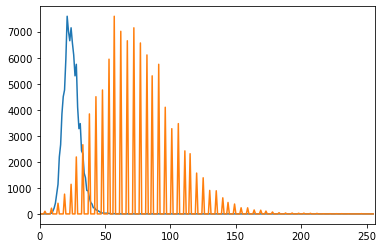

alpha 4.811320754716981
beta -43.30188679245283


In [20]:
if __name__ == '__main__' :

    imag = cv2.imread(path + photo_name + ".tif")    # Read image

    if imag is None:
        print("Check file path")
    else:
        r = sparks_analysis.select_roi (imag) # Select ROI
        imCrop = sparks_analysis.crop_image (imag, r)    # Crop image
        sparks_analysis.display_image ('Image' , imCrop)    # Display cropped image
        
image = cv2.imread(path + photo_name + ".tif")
auto_result, alpha, beta = sparks_analysis.automatic_brightness_and_contrast(imCrop)
print('alpha', alpha)
print('beta', beta)
cv2.imshow('auto_result', auto_result)
# cv2.imwrite('auto_result.png', auto_result)
cv2.imshow('image', imCrop)
cv2.waitKey()
cv2.destroyAllWindows()

dilate = sparks_analysis.filtration (auto_result)[0]
original = sparks_analysis.filtration (auto_result)[1]

cnts = sparks_analysis.find_contourns (dilate)    # Find contours

# Iterate thorugh contours and filter for ROI
list_img_col = []
track_number = 0
for c in cnts:
    img_col_mean = sparks_analysis.track_contours (c, auto_result, track_number) [0]
    track_number +=1
    list_img_col.append (img_col_mean)
#     plot_histogram (img_col_mean, nombre_foto, "time", "Intensity")    #gráfico de histograma

#     cv2.imwrite("ROI_{}.png".format(track_number), ROI)
#     track_number += 1

sparks_analysis.display_image ('image' , auto_result)

from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

img_bc = interactive(f, brightness=100, contrast=100)   #display brightness and contrast
display (img_bc)

im = rotation (imCrop, 90)    # rotate image
display_image ('Image' , im)    # Display cropped image

## **Aplicación de análisis sobre picos** 

In [21]:
def maximo_peak (vector):
    import numpy as np
    from peakutils.peak import indexes
    import peakutils
    indexes = indexes(np.array(vector), thres=1.0/max(vector), min_dist=10)
    kk = list(indexes)
    for j in kk:
        if vector[j]> (sum(vector) / len(vector)):
            tiempos = j
            intensidades = vector[j]
    return tiempos,intensidades

cantidad_sparks = len(list_img_col)

datos_tiempos = {}
datos_intensidades = {}

for i in range (0,cantidad_sparks):
    picos = maximo_peak (list_img_col[i])
    datos_tiempos [i] = picos [0]
    datos_intensidades [i] = picos [1]
    

Columns = ['Spark_'+ str(x) for x in range(0, cantidad_sparks)]
out_sparks = pd.DataFrame([datos_tiempos.values(),datos_intensidades.values()], columns = Columns).T
out_sparks = pd.DataFrame(out_sparks.values, columns = ['tiempo_maximo', 'intensidad_maxima'])

In [22]:
#  Detección de mínimos locales
# Calculate the n-th discrete difference along the given axis. The first difference is given by out[i] = a[i+1] - a[i] along the given axis, higher differences are calculated by using diff recursively.
# The sign function returns -1 if x < 0, 0 if x==0, 1 if x > 0. nan is returned for nan inputs.

def minimo_bl (vector):
    data = np.asarray(vector,dtype=np.int)
    b = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1
    return b

# Esta celda calcula los mínimos de la selección de toda la célula tomando los mínimos calculados, quedandose con el más chico entre dos máximos.
# Devuelve el valor de tiempos y las intensidades en dataframes por separado.

sparks_tiempo0 = []
sparks_intensidad0 = []        
sparks_tiempo_n = []
sparks_intensidad_n = []

for i in range (0,cantidad_sparks):
    picos = minimo_bl (list_img_col[i])
    lista_min = []
    for minimo in picos:
        picomenor = int(out_sparks['tiempo_maximo'][i])
        if minimo < picomenor:
            y_min = list_img_col[i] [minimo]
            lista_min.append((minimo,y_min))
    try:
        minimo_lista_mins = min(lista_min, key = lambda t: t[1])
        sparks_tiempo0.append(minimo_lista_mins[0])
        sparks_intensidad0.append (minimo_lista_mins[1])
    except ValueError:
        minimo_lista_mins = min (list_img_col[i][0:int(out_sparks['tiempo_maximo'][i])])
        minimimo = list_img_col[i].index(minimo_lista_mins)
        sparks_tiempo0.append(minimimo)
        sparks_intensidad0.append (minimo_lista_mins)

out_sparks['tiempo_minimo'] = sparks_tiempo0
out_sparks['intensidad_minima'] = sparks_intensidad0

# final minimun

for i in range (0,cantidad_sparks):
    picos = minimo_bl (list_img_col[i])
    lista_min = []
    for minimo in picos:
        picomenor = int(out_sparks['tiempo_maximo'][i])
        if minimo > picomenor:
            y_min = list_img_col[i] [minimo]
            lista_min.append((minimo,y_min))
    try:
        minimo_lista_mins = min(lista_min, key = lambda t: t[1])
        sparks_tiempo_n.append(minimo_lista_mins[0])
        sparks_intensidad_n.append (minimo_lista_mins[1])
    except ValueError:
        minimo_lista_mins = min (list_img_col[i][int(out_sparks['tiempo_maximo'][i]):len (list_img_col[i])])
        minimimo = list_img_col[i].index(minimo_lista_mins)
        sparks_tiempo_n.append(minimimo)
        sparks_intensidad_n.append (minimo_lista_mins)

out_sparks['tiempo_valle'] = sparks_tiempo_n
out_sparks['intensidad_valle'] = sparks_intensidad_n

In [23]:
# Calcula la amplitud de cada pico como la diferencia entre la intensidad máximo y mínimo 

sparks_amplitud = []
for sp in range(0, cantidad_sparks):
    sp_amplitud = (out_sparks['intensidad_maxima'] [sp] - out_sparks['intensidad_minima'] [sp])/out_sparks['intensidad_minima'] [sp]
    sparks_amplitud.append(sp_amplitud)
out_sparks['amplitud'] = sparks_amplitud

In [24]:
# Cálculo del tiempo al pico como la diferencia en el tiempo máximo y mínimo para toda la selección

sparks_tiempo_al_pico = []
for sp in range  (0, cantidad_sparks):
    sp_ttp = out_sparks['tiempo_maximo'] [sp] - out_sparks['tiempo_minimo'] [sp]
    sparks_tiempo_al_pico.append(sp_ttp)
out_sparks['TTP'] = sparks_tiempo_al_pico

In [25]:
import scipy.stats

# Calcula el tiempo al 50% del pico de cada pico de la selección

sparks_tiempo_pico50 = []

for sp in range  (0, cantidad_sparks):
    sp_amp50 = (out_sparks['intensidad_maxima'] [sp] + out_sparks['intensidad_minima'] [sp])/2   
    x1 = np.asarray (range (int(out_sparks['tiempo_minimo'] [sp]), int(out_sparks['tiempo_maximo'] [sp]+1))) 
    y1 = np.asarray (list_img_col [sp] [int(out_sparks['tiempo_minimo'] [sp]) : int(out_sparks['tiempo_maximo'] [sp]+1)])
    ySS = 0
    (amplitudeEst,tauEst) = sparks_analysis.fitExponent(x1,y1,ySS)
    yEst = amplitudeEst*(exp(-x1/tauEst))+ySS
    sp_ttp50 = (np.log((sp_amp50 -ySS)/ amplitudeEst))*(-tauEst)
    sparks_tiempo_pico50.append (sp_ttp50)
out_sparks['TTP50'] = sparks_tiempo_pico50 - out_sparks['tiempo_minimo']

# Calculo del FDHM
sparks_tiempo_pico50_2 = []
for sp in range  (0, cantidad_sparks):
    sp_amp50 = (out_sparks['intensidad_maxima'] [sp] + out_sparks['intensidad_minima'] [sp])/2
    x2 = np.asarray (range (int(out_sparks['tiempo_maximo'] [sp]), int(out_sparks['tiempo_valle'] [sp]+1))) 
    y2 = np.asarray (list_img_col [sp] [int(out_sparks['tiempo_maximo'] [sp]) : int(out_sparks['tiempo_valle'] [sp]+1)])
    (amplitudeEst2,tauEst2) = sparks_analysis.fitExponent(x2,y2,ySS)  
    yEst2 = amplitudeEst2*(exp(-x2/tauEst2))+ySS
    sp_ttp50_2 = (np.log((sp_amp50 -ySS)/ amplitudeEst2))*(-tauEst2)
    sparks_tiempo_pico50_2.append (sp_ttp50_2)
out_sparks['FDHM'] =[A - B for (A, B) in zip(sparks_tiempo_pico50_2, sparks_tiempo_pico50)]

C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [26]:
# Aplico la función para tau a la selección

sp_tau = []
for sp in range (0, cantidad_sparks):
    x = np.asarray(list (range(int(out_sparks['tiempo_maximo'] [sp]), int(out_sparks['tiempo_valle'] [sp])+1))) #* x_calibracion
    y = np.asarray(list_img_col[sp][int(out_sparks['tiempo_maximo'] [sp]) : int(out_sparks['tiempo_valle'] [sp])+1],dtype=np.float64)
    ySS = 0
    (amplitudeEst,tauEst) = sparks_analysis.fitExponent(x,y,ySS)
    yEst = amplitudeEst*(exp(-x/tauEst))+ySS
    sp_tau.append (tauEst)

out_sparks['tau'] = sp_tau

C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [27]:
##  Calculo de (ΔF/F0)/ΔTmax

out_sparks['(ΔF/F0)/ΔTmax'] = out_sparks['amplitud']/out_sparks['TTP']

##  Calculo fullDuration

out_sparks['fullDuration'] = out_sparks['tiempo_valle'] - out_sparks['tiempo_minimo']

In [28]:
# Iterate thorugh contours and filter for ROI para el ancho de pico
list_img_row = []
track_number = 0
for c in cnts:
    img_row_mean = sparks_analysis.track_contours (c, auto_result, track_number) [1]
    track_number +=1
    list_img_row.append (img_row_mean)

sparks_analysis.display_image ('image' , auto_result)

def maximo_peak (vector):
    import numpy as np
    from peakutils.peak import indexes
    import peakutils
    indexes = indexes(np.array(vector), thres=1.0/max(vector), min_dist=10)
    kk = list(indexes)
    for j in kk:
        if vector[j]> (sum(vector) / len(vector)):
            tiempos = j
            intensidades = vector[j]
    return tiempos,intensidades

cantidad_sparks = len(list_img_row)

datos_tiempos = {}
datos_intensidades = {}

for i in range (0,cantidad_sparks):
    picos = maximo_peak (list_img_row[i])
    datos_tiempos [i] = picos [0]
    datos_intensidades [i] = picos [1]
    

Columns = ['Spark_'+ str(x) for x in range(0, cantidad_sparks)]
out_sparks_row = pd.DataFrame([datos_tiempos.values(),datos_intensidades.values()], columns = Columns).T
out_sparks_row = pd.DataFrame(out_sparks_row.values, columns = ['tiempo_maximo', 'intensidad_maxima'])

# Esta celda calcula los mínimos de la selección de toda la célula tomando los mínimos calculados, quedandose con el más chico entre dos máximos.
# Devuelve el valor de tiempos y las intensidades en dataframes por separado.

sparks_tiempo0 = []
sparks_intensidad0 = []        
sparks_tiempo_n = []
sparks_intensidad_n = []

for i in range (0,cantidad_sparks):
    picos = minimo_bl (list_img_row[i])
    lista_min = []
    for minimo in picos:
        picomenor = int(out_sparks_row['tiempo_maximo'][i])
        if minimo < picomenor:
            y_min = list_img_row[i] [minimo]
            lista_min.append((minimo,y_min))
    try:
        minimo_lista_mins = min(lista_min, key = lambda t: t[1])
        sparks_tiempo0.append(minimo_lista_mins[0])
        sparks_intensidad0.append (minimo_lista_mins[1])
    except ValueError:
        minimo_lista_mins = min (list_img_row[i][0:int(out_sparks['tiempo_maximo'][i])])
        minimimo = list_img_row[i].index(minimo_lista_mins)
        sparks_tiempo0.append(minimimo)
        sparks_intensidad0.append (minimo_lista_mins)

out_sparks_row['tiempo_minimo'] = sparks_tiempo0
out_sparks_row['intensidad_minima'] = sparks_intensidad0

# final minimun

for i in range (0,cantidad_sparks):
    picos = minimo_bl (list_img_row[i])
    lista_min = []
    for minimo in picos:
        picomenor = int(out_sparks['tiempo_maximo'][i])
        if minimo > picomenor:
            y_min = list_img_row[i] [minimo]
            lista_min.append((minimo,y_min))
    try:
        minimo_lista_mins = min(lista_min, key = lambda t: t[1])
        sparks_tiempo_n.append(minimo_lista_mins[0])
        sparks_intensidad_n.append (minimo_lista_mins[1])
    except ValueError:
        minimo_lista_mins = min (list_img_row[i][int(out_sparks['tiempo_maximo'][i]):len (list_img_row[i])])
        minimimo = list_img_row[i].index(minimo_lista_mins)
        sparks_tiempo_n.append(minimimo)
        sparks_intensidad_n.append (minimo_lista_mins)

out_sparks_row['tiempo_valle'] = sparks_tiempo_n
out_sparks_row['intensidad_valle'] = sparks_intensidad_n

In [29]:
##  Calculo fullWidth

out_sparks['fullWidth'] = out_sparks_row['tiempo_valle'] - out_sparks_row['tiempo_minimo']

In [30]:
import scipy.stats

# Calculo del FWHM

sparks_tiempo_pico50 = []

for sp in range  (0, cantidad_sparks):
    sp_amp50 = (out_sparks_row['intensidad_maxima'] [sp] + out_sparks_row['intensidad_minima'] [sp])/2   
    x1 = np.asarray (range (int(out_sparks_row['tiempo_minimo'] [sp]), int(out_sparks_row['tiempo_maximo'] [sp]+1))) 
    y1 = np.asarray (list_img_row [sp] [int(out_sparks_row['tiempo_minimo'] [sp]) : int(out_sparks_row['tiempo_maximo'] [sp]+1)])
    ySS = 0
    (amplitudeEst,tauEst) = sparks_analysis.fitExponent(x1,y1,ySS)
    yEst = amplitudeEst*(exp(-x1/tauEst))+ySS
    sp_ttp50 = (np.log((sp_amp50 -ySS)/ amplitudeEst))*(-tauEst)
    sparks_tiempo_pico50.append (sp_ttp50)
out_sparks_row['TTP50'] = sparks_tiempo_pico50 - out_sparks_row['tiempo_minimo']


sparks_tiempo_pico50_2 = []
for sp in range  (0, cantidad_sparks):
    sp_amp50 = (out_sparks_row['intensidad_maxima'] [sp] + out_sparks_row['intensidad_minima'] [sp])/2
    x2 = np.asarray (range (int(out_sparks_row['tiempo_maximo'] [sp]), int(out_sparks_row['tiempo_valle'] [sp]+1))) 
    y2 = np.asarray (list_img_row [sp] [int(out_sparks_row['tiempo_maximo'] [sp]) : int(out_sparks_row['tiempo_valle'] [sp]+1)])
    (amplitudeEst2,tauEst2) = sparks_analysis.fitExponent(x2,y2,ySS)  
    yEst2 = amplitudeEst2*(exp(-x2/tauEst2))+ySS
    sp_ttp50_2 = (np.log((sp_amp50 -ySS)/ amplitudeEst2))*(-tauEst2)
    sparks_tiempo_pico50_2.append (sp_ttp50_2)
out_sparks['FWHM'] =[A - B for (A, B) in zip(sparks_tiempo_pico50_2, sparks_tiempo_pico50)]

10 10
3 3
4 4
3 3
5 5
2 2
6 6
8 8
14 14
4 4
12 12
3 3


C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [31]:
out_sparks_row

,tiempo_maximo,intensidad_maxima,tiempo_minimo,intensidad_minima,tiempo_valle,intensidad_valle,TTP50
0,6.0,138.363636,2,82.909091,15,81.272727,2.178061
1,5.0,136.222222,1,92.000000,7,112.888889,2.312120
2,9.0,150.944444,3,82.000000,12,101.055556,2.875881
3,5.0,155.846154,2,101.769231,7,109.923077,1.895327
4,5.0,121.384615,0,78.461538,9,71.769231,3.238165
5,10.0,152.153846,2,81.307692,11,121.076923,3.675918
6,7.0,167.833333,1,83.750000,12,108.666667,3.196722
7,7.0,173.666667,2,87.222222,14,65.888889,2.969145
8,8.0,136.500000,1,72.181818,21,67.954545,4.643545
9,11.0,163.850000,7,133.250000,14,115.800000,1.384518
